In [1]:
# !pip install -q git+https://github.com/samoturk/mol2vec;

In [2]:
# !pip install -q huggingface-hub transformers catboost xgboost lightgbm torch gensim==3.7.1

In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from utils import PreprocessSMILES, SimpleRegressions, SmallNN, LstmRegressor, DataLoader, Training

from utils import load_config, seed_everything

import gensim

print(gensim.__version__) # 3.7.1

2024-04-21 16:46:22.414032: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-21 16:46:51.433445: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-04-21 16:46:51.434014: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2024-04-21 16:46:51.434080: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

3.7.1


## Майнинг данных из SMILES и объединение молекул в смеси

In [4]:
############################################################################################################################################
directory = './materials/'
preprocessor = PreprocessSMILES(directory, 'canonical_smiles')
mdf = preprocessor.preprocess_data("train_data_fix_concat.csv", "descriptors.csv")
grouped_mdf = preprocessor.preprocess_mol2vec(mdf)
smiles_df = preprocessor.smiles2sentence(mdf)
joined_df = pd.merge(grouped_mdf, smiles_df, on='blend_id', how='inner').dropna() # TODO: fix nan
joined_df = preprocessor.embed_smiles(joined_df, 'DeepChem/ChemBERTa-10M-MTR') # ibm/MoLFormer-XL-both-10pct DeepChem/ChemBERTa-10M-MTR
joined_df.reset_index(drop=True, inplace=True)
mdf['graphs'] = preprocessor.generate_graphs(mdf)
mdf.drop(columns=['oil_property_param_title', 'oil_property_param_value', 'mol'], inplace=True)
joined_df.head(3)
# X, y = preprocessor.xy_split(joined_df, column = 'embeddings')

Fetching 11 files:   0%|          | 0/11 [00:00<?, ?it/s]

Some weights of the model checkpoint at ./materials/embed_model/DeepChem/ChemBERTa-10M-MTR/models--DeepChem--ChemBERTa-10M-MTR/snapshots/b65d0a6af3156071d9519e867d695aa265bb393f were not used when initializing RobertaModel: ['regression.dense.weight', 'norm_std', 'regression.out_proj.weight', 'norm_mean', 'regression.dense.bias', 'regression.out_proj.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at ./materials/embed_model/DeepChem/ChemBERTa-10M-MTR/models--DeepChem--ChemBERTa-10M-MTR/snapshots/b65d0

,blend_id,sentence,mol2vec,oil_property_param_title,canonical_smiles,smiles,descriptors_array,oil_property_param_value,similarity_vectors,embeddings
0,007b4d7a-b1f8-11ed-93b4-005056921581,"[2246728737, 3537119515, 2245273601, 242354360...","[-3.4431674, -0.62736166, -2.157891, -0.715889...",ad7e6027-00b8-4c27-918c-d1561f949ad8,"CCCCCC(C)C, CCCC(C)CCC, CCCCC","CC(C)CCCCC, CCCC(C)CCC, CCCCC","[6.0, 21.0, 0.0, 0.0, 0.0, 69.0, 21.0, 13.0560...",13360.0,"[0.3888888888888889, 0.4, 0.2857142857142857]","[-0.19337868690490723, 0.05811728537082672, -0..."
1,0109d480-f91d-11ec-96ac-005056921581,"[2246728737, 3542456614, 2245384272, 150656359...","[-5.5208826, 0.3777768, -3.6566508, -1.7744193...",ad7e6027-00b8-4c27-918c-d1561f949ad8,"CCCCC(C)CC, CCCC(C)CCC, CCCCC, CCCCC(C)C, CCCC...","CCC(C)CCCC, CCCC(C)CCC, CCCCC, CCCCC(C)C, O=C(...","[24.0, 36.0, 2.0, 0.0, 0.0, 118.0, 38.0, 24.13...",111400.0,"[0.4444444444444444, 0.375, 0.5555555555555556...","[-0.11401204019784927, 0.03136511147022247, -0..."
2,01bc9ed0-0f2f-11ed-9900-005056921581,"[2246728737, 3542456614, 2245384272, 150656359...","[-2.5844321, 0.054932743, -2.082138, -0.734171...",ad7e6027-00b8-4c27-918c-d1561f949ad8,"CCC(CC)C(=O)OC, CCCC(C)CCC, CCCCC","CCC(C(OC)=O)CC, CCCC(C)CCC, CCCCC","[3.0, 20.0, 2.0, 0.0, 0.0, 66.0, 22.0, 13.6133...",16325.0,"[0.16666666666666666, 0.14285714285714285, 0.2...","[-0.15800337493419647, 0.057720303535461426, -..."


In [5]:
len(joined_df['descriptors_array'][0]) # сумма дескрипторов по соединению

830

In [6]:
# TODO: пример графа, на данный момент не используется

mdf['graphs'][0]

Graph(num_nodes=8, num_edges=14,
      ndata_schemes={'feat': Scheme(shape=(1,), dtype=torch.float32)}
      edata_schemes={'type': Scheme(shape=(1,), dtype=torch.float32)})

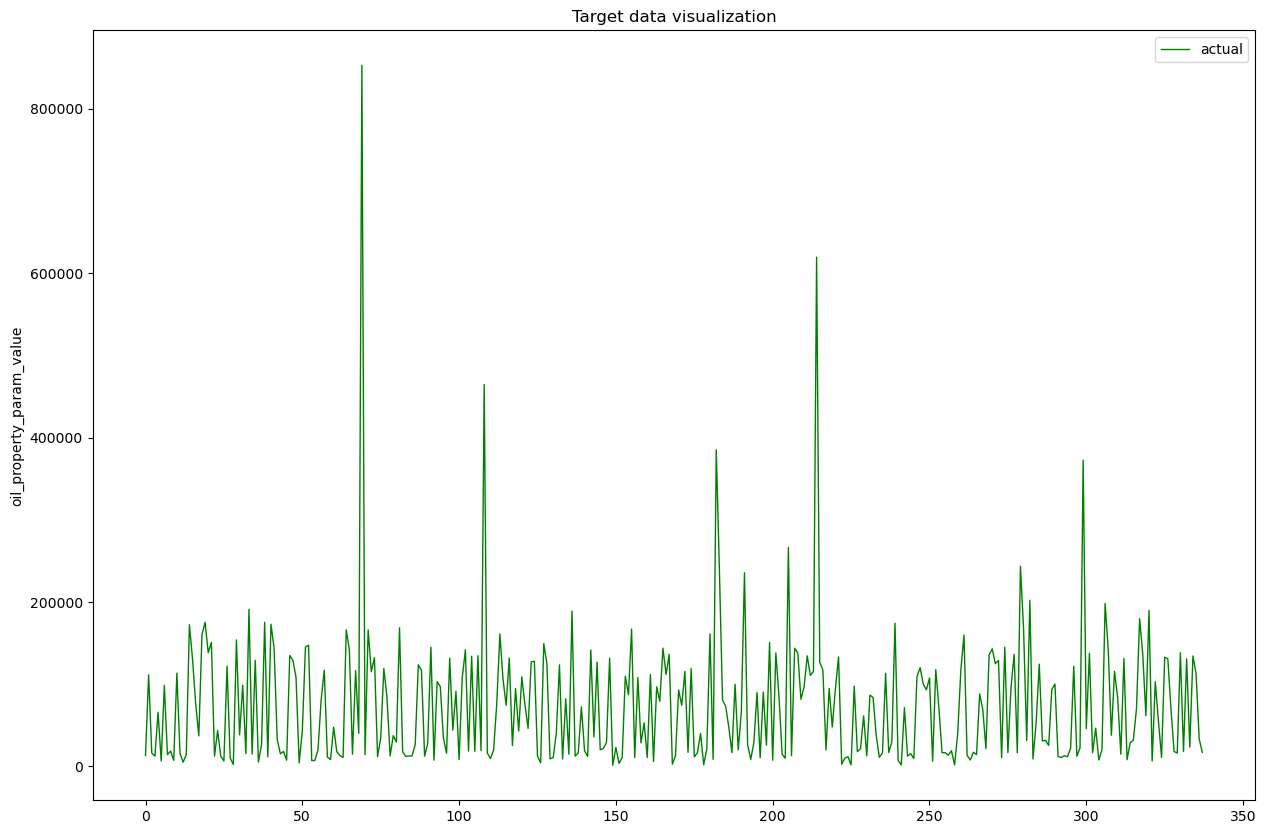

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 10))
plt.plot(joined_df['oil_property_param_value'], "green", label="actual", linewidth=1.0)
plt.legend()
plt.ylabel("oil_property_param_value")
plt.title("Target data visualization")
plt.show()


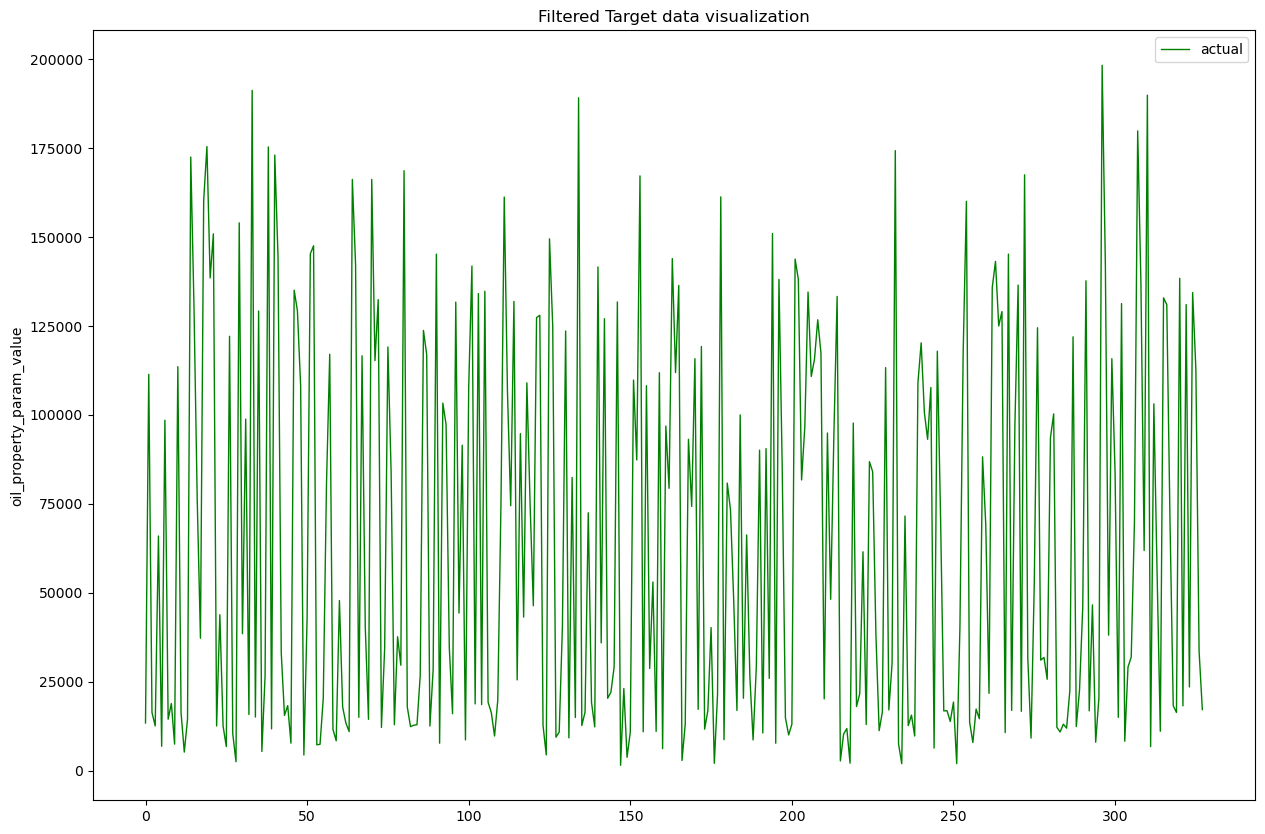

In [8]:
## Удаление выбросов для обучения

filtered_df = joined_df[joined_df['oil_property_param_value'] < 200000].reset_index(drop=True)

plt.figure(figsize=(15, 10))
plt.plot(filtered_df['oil_property_param_value'], "green", label="actual", linewidth=1.0)
plt.legend()
plt.ylabel("oil_property_param_value")
plt.title("Filtered Target data visualization")
plt.show()

## Подготовка данных для обучения на объединенных последовательностях векторов, эмбедингов смеси и близости расстояний между молекулами.


In [9]:
# как similarity_score используется TanimotoSimilarity из rdkit

static_cols = ['embeddings'] #['mol2vec', 'embeddings', 'descriptors_array']
dynamic_cols = [] #['similarity_vectors']

data_loader = DataLoader(filtered_df, static_cols, dynamic_cols)
dataset = data_loader.get_dataset()

Shape of data_x: (328, 1, 384)
Shape of data_y: (328, 1)


## Тренировка

In [10]:
# Тренировка 3 архитектур нейросеток

config = load_config("config.yml", "embeddings", "torchRegressor")
seed_everything()
trainer = Training(config, dataset.data_x, cross_validation = False, y=dataset.data_y)

# pred1 = trainer.average_prediction(test, models)
# pred2 = trainer.weighted_average_prediction(test, models, model_wise=[0.29, 0.33, 0.38], fold_wise=[0.30, 0.35, 0.35])

-----Seed Set!-----


In [11]:
trainer.trained_models

[GRURegressor(
   (gru): GRU(32, 2, num_layers=2, batch_first=True)
   (linear): Sequential(
     (0): Linear(in_features=26, out_features=1024, bias=True)
     (1): Dropout(p=0.3, inplace=False)
     (2): ReLU()
     (3): Linear(in_features=1024, out_features=512, bias=True)
     (4): Dropout(p=0.3, inplace=False)
     (5): ReLU()
   )
   (head1): Linear(in_features=512, out_features=1, bias=True)
   (loss1): MSELoss()
   (loss3): L1Loss()
 ),
 ConvRegressor(
   (conv_block): Sequential(
     (0): Conv1d(1, 8, kernel_size=(5,), stride=(1,))
     (1): Dropout(p=0.3, inplace=False)
     (2): Conv1d(8, 8, kernel_size=(5,), stride=(1,))
     (3): ReLU()
     (4): Conv1d(8, 16, kernel_size=(5,), stride=(2,))
     (5): Dropout(p=0.3, inplace=False)
     (6): AvgPool1d(kernel_size=(11,), stride=(11,), padding=(0,))
     (7): Conv1d(16, 4, kernel_size=(3,), stride=(3,))
     (8): Flatten(start_dim=1, end_dim=-1)
   )
   (linear): Sequential(
     (0): Linear(in_features=20, out_features=1024,

## Тренировка других моделей

In [12]:
dataset.data_x.shape

(328, 1, 384)

In [11]:
config = load_config("config.yml", "embeddings", "SmallNN")
regression_models = SimpleRegressions(X=dataset.data_x.reshape(config['input']), y=dataset.data_y.reshape(config['input'][0]))
regression_models.fit_and_evaluate()

In [14]:
from utils import SmallNN

nn_model = SmallNN(X=dataset.data_x.reshape(config['input']), y=dataset.data_y.reshape(config['input'][0]), config=config)
nn_model.fit_and_evaluate()

2024-04-21 15:59:30.400555: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2024-04-21 15:59:30.401126: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2024-04-21 15:59:30.401657: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (LAPTOP-HPESRLBL): /proc/driver/nvidia/version does not exist
2024-04-21 15:59:30.410955: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/1000
15/15 [==============================] - 3s 53ms/step - loss: 0.7904 - mean_absolute_error: 0.4655 - val_loss: 0.1005 - val_mean_absolute_error: 0.2597 - lr: 0.0300
Epoch 2/1000
15/15 [==============================] - 0s 12ms/step - loss: 0.0652 - mean_absolute_error: 0.2136 - val_loss: 0.0645 - val_mean_absolute_error: 0.2075 - lr: 0.0300
Epoch 3/1000
15/15 [==============================] - 0s 12ms/step - loss: 0.0550 - mean_absolute_error: 0.1814 - val_loss: 0.0631 - val_mean_absolute_error: 0.1963 - lr: 0.0300
Epoch 4/1000
15/15 [==============================] - 0s 11ms/step - loss: 0.0601 - mean_absolute_error: 0.1872 - val_loss: 0.0682 - val_mean_absolute_error: 0.2090 - lr: 0.0300
Epoch 5/1000
15/15 [==============================] - 0s 7ms/step - loss: 0.0576 - mean_absolute_error: 0.1906 - val_loss: 0.0776 - val_mean_absolute_error: 0.2261 - lr: 0.0300
Epoch 6/1000
15/15 [==============================] - 0s 18ms/step - loss: 0.0633 - mean_absolute_error: 0.1963

KeyboardInterrupt: 

In [13]:
from sklearn.model_selection import train_test_split
scaler_ = StandardScaler() # RobustScaler

regressor = LstmRegressor(units=50, dropout_rate=0.005, optimizer='rmsprop', epochs=200, 
                          batch_size=8, neurons_1 = 128, neurons_2 = 64, scaler=scaler_)

X_train, X_test, y_train, y_test = train_test_split(
            dataset.data_x.reshape(config['input']), dataset.data_y.reshape(config['input'][0]), test_size=0.2, random_state=42
        )
model, _ = regressor.fit(X_train, y_train, X_test, y_test)

2024-04-21 16:20:24.005823: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2024-04-21 16:20:24.008007: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2024-04-21 16:20:24.009102: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (LAPTOP-HPESRLBL): /proc/driver/nvidia/version does not exist
2024-04-21 16:20:24.020101: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/200
20/37 [===============>..............] - ETA: 16s - loss: 1.0267

KeyboardInterrupt: 